In [201]:
import pandas as pd
import os
import seaborn as sns
import numpy as np 
import random 
import pickle
from math import pi 
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn                 as sns
import statsmodels.api         as sm
import statsmodels.formula.api as smf
from sqlalchemy import create_engine, text
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans 
%matplotlib inline
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from fancyimpute import KNN
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


# import warnings filter
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [202]:
df1=pd.read_csv('/data_etls/ecar_dwh_base_modelo.csv')
df1.rename(str.lower, axis='columns', inplace=True)

## Imputing missing values  with KNN algorithm

In [3]:
for i in ['educacion_formal', 'estado_educacion', 'nombre_educacion']:
    df1[i]=df1[i].replace('no_disponible', np.nan)

In [4]:
df1=df1[df1['codenc']!='Encuestador 290']
df_trans=df1.copy()
df_final=df_trans.copy()

In [5]:
#instantiate both packages to use
encoder = OrdinalEncoder()
imputer = KNN()
# create a list of categorical columns to iterate over
cat_cols = ['como_conocio_cnc', 'localidad', 'educacion_formal', 'estado_educacion', 'nombre_educacion']

def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#create a for loop to iterate through each column in the data
for columns in cat_cols:
    encode(df_trans[columns])

/Users/jessicasalas/env/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jessicasalas/env/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jessicasalas/env/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [6]:
df_trans=df_trans.set_index('codenc')

In [7]:
encode_data = pd.DataFrame(np.round(imputer.fit_transform(df_trans[cat_cols])),columns =cat_cols)

Imputing row 1/283 with 0 missing, elapsed time: 0.041
Imputing row 101/283 with 1 missing, elapsed time: 0.052
Imputing row 201/283 with 3 missing, elapsed time: 0.059
[KNN] Warning: 555/1415 still missing after imputation, replacing with 0


In [8]:
encode_data['como_conocio_cnc'].replace([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], ['internet - computrabajo.com', 'internet - pagina web del cnc', 'internet - zonajobs.com',  'otros', 'periodico - adn', 'periodico - el tiempo', 'voz a voz- referido por un conocido'], inplace=True)
encode_data['localidad'].replace([0.0, 1.0, 2.0, 3.0, 4.0], ['centro oriente', 'norte',  'otros', 'sur', 'sur_occidente'], inplace=True)
encode_data['educacion_formal'].replace([0.0, 1.0, 2.0, 3.0], ['bachiller', 'profesional', 'tecnólogo', 'técnico'], inplace=True)
encode_data['estado_educacion'].replace([0.0, 1.0, 2.0], ['actualmente', 'aplazado', 'culminado'], inplace=True)
encode_data['nombre_educacion'].replace([0.0, 1.0, 2.0], ['ciencias administrativas y contables', 'ciencias ambientales y salud', 'otros'], inplace=True)
encode_data.shape
df1.shape

(283, 55)

In [9]:
encode_data['codenc']=df1['codenc']
encode_data=encode_data[['codenc', 'como_conocio_cnc', 'localidad', 'educacion_formal', 'estado_educacion', 'nombre_educacion']]

In [10]:
df1=df1.merge(encode_data, on='codenc', how='left')

In [11]:
num=['competencias_funcionales', 'numeros', 'lectura_voz_alta','fluidez_lectura', 'cartografia', 
     'competencias_organizacionales','sumar', 'coherencia_entre_numeros']

In [12]:
encode_data2 = pd.DataFrame(imputer.fit_transform(df1[num]),columns =num)
encode_data2['codenc']=df1['codenc']
df1=df1.merge(encode_data2, on='codenc', how='left')

Imputing row 1/283 with 0 missing, elapsed time: 0.032
Imputing row 101/283 with 0 missing, elapsed time: 0.041
Imputing row 201/283 with 0 missing, elapsed time: 0.046
[KNN] Warning: 888/2264 still missing after imputation, replacing with 0


In [13]:
df1.drop(['como_conocio_cnc_x','localidad_x', 'educacion_formal_x', 'estado_educacion_x',
       'nombre_educacion_x', 'competencias_funcionales_x', 'numeros_x', 'lectura_voz_alta_x',
       'fluidez_lectura_x', 'cartografia_x', 'competencias_organizacionales_x',
       'sumar_x', 'coherencia_entre_numeros_x'], axis=1, inplace=True)

In [14]:
df1.columns=['codenc', 'calls', 'total', 'espera', 'hablado', 'disponible', 'pausas',
       'muerto', 'duracion_efectivas', 'dias_trabajados',
       'efectividad_ajustada', 'efectivas_mujer', 'efectivas_hombre',
       'efectivas_alto', 'efectivas_medio_alto', 'efectivas_medio_medio',
       'efectivas_bajo', 'efectivas_medio_bajo', 'efectivas_tunja',
       'efectivas_popayán', 'efectivas_montería', 'efectivas_manizales',
       'efectivas_armenia', 'efectivas_villavicencio', 'efectivas_pasto',
       'efectivas_cúcuta', 'efectivas_santa_marta', 'efectivas_ibagué',
       'efectivas_neiva', 'efectivas_pereira', 'efectivas_cartagena',
       'efectivas_cali', 'efectivas_bucaramanga', 'efectivas_barranquilla',
       'efectivas_medellín', 'efectivas_bogotá', 'efectivas_rango_edad_5',
       'efectivas_rango_edad_2', 'efectivas_rango_edad_4',
       'efectivas_rango_edad_3', 'efectivas_rango_edad_1', 'meses_trabajados',
        'como_conocio_cnc','localidad', 'educacion_formal', 'estado_educacion',
       'nombre_educacion', 
        'competencias_funcionales', 'numeros', 'lectura_voz_alta',
       'fluidez_lectura', 'cartografia', 'competencias_organizacionales',
       'sumar', 'coherencia_entre_numeros']

# EDA

### The business problem is identify the main causes of difference in productivity across the pollsters, for that reason we want to pronostique the efective calls by pollsters according to relationship between the other variables

In [15]:
cols_num=['calls', 'total', 'espera', 'hablado', 'disponible', 'pausas','muerto', 'duracion_efectivas', 
        'dias_trabajados','meses_trabajados','competencias_funcionales', 'numeros', 'lectura_voz_alta',
        'fluidez_lectura', 'cartografia', 'competencias_organizacionales','sumar', 'coherencia_entre_numeros']

cols_cat=['como_conocio_cnc','localidad', 'educacion_formal', 'estado_educacion', 'nombre_educacion']

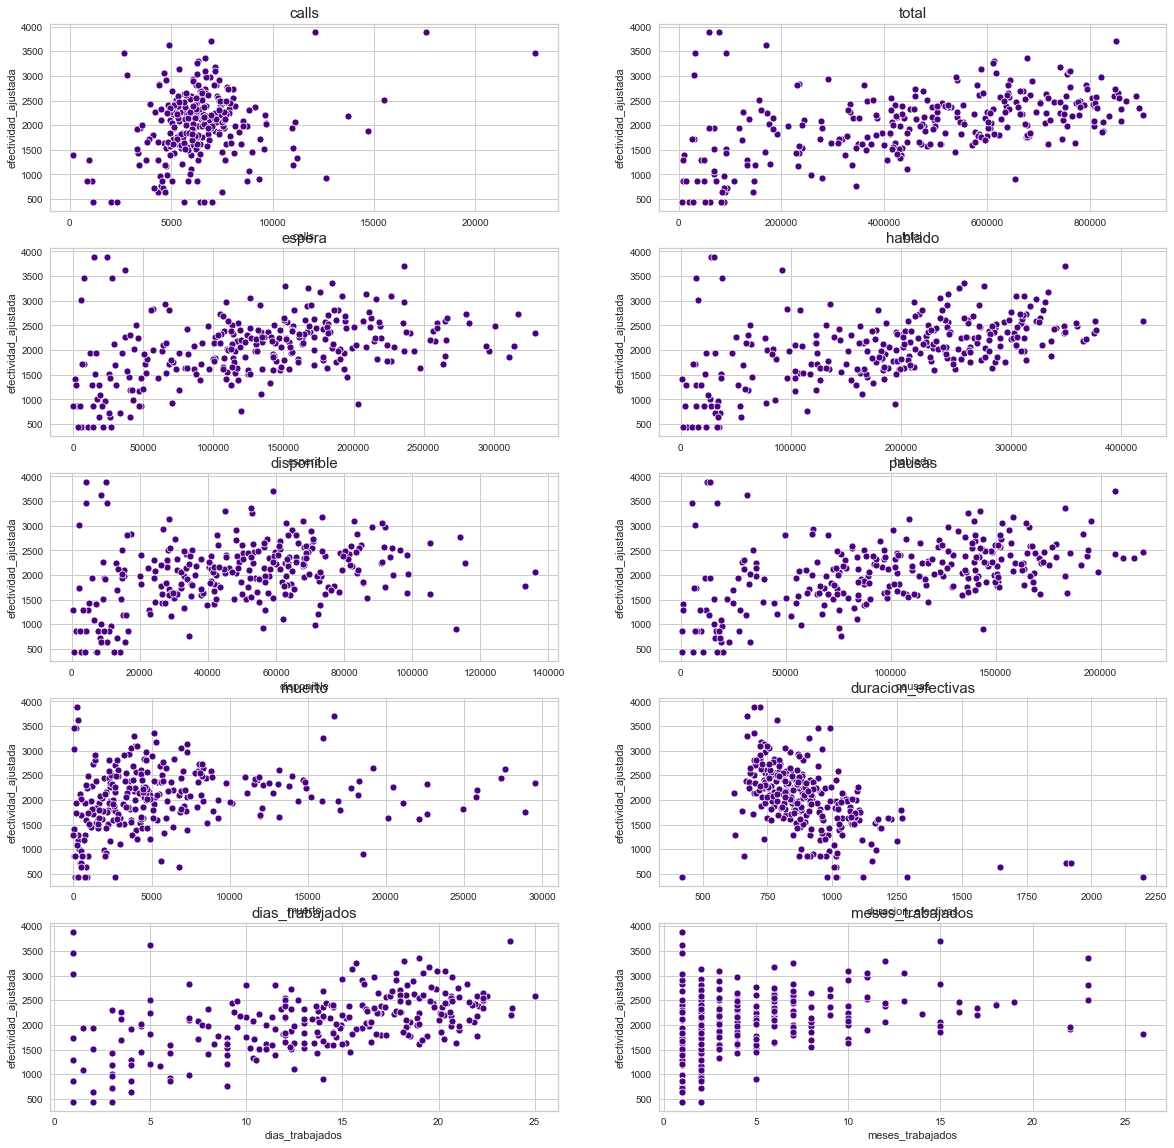

In [16]:
fig, ax = plt.subplots(ncols=2, nrows=5,figsize=(20,20))
for col, axis in zip(cols_num, ax.flatten()):        
    ax_ = sns.scatterplot(x=col,y='efectividad_ajustada', data=df1, ax=axis, color="indigo")
    axis.set_title(col, fontsize=15)

In [17]:
df1.groupby('como_conocio_cnc')['codenc'].count()

df1['como_conocio_cnc'].replace({'internet - zonajobs.com': 'internet - computrabajo.com',
             'periodico - adn':'otros' ,'periodico - el tiempo':'otros'}, inplace=True)

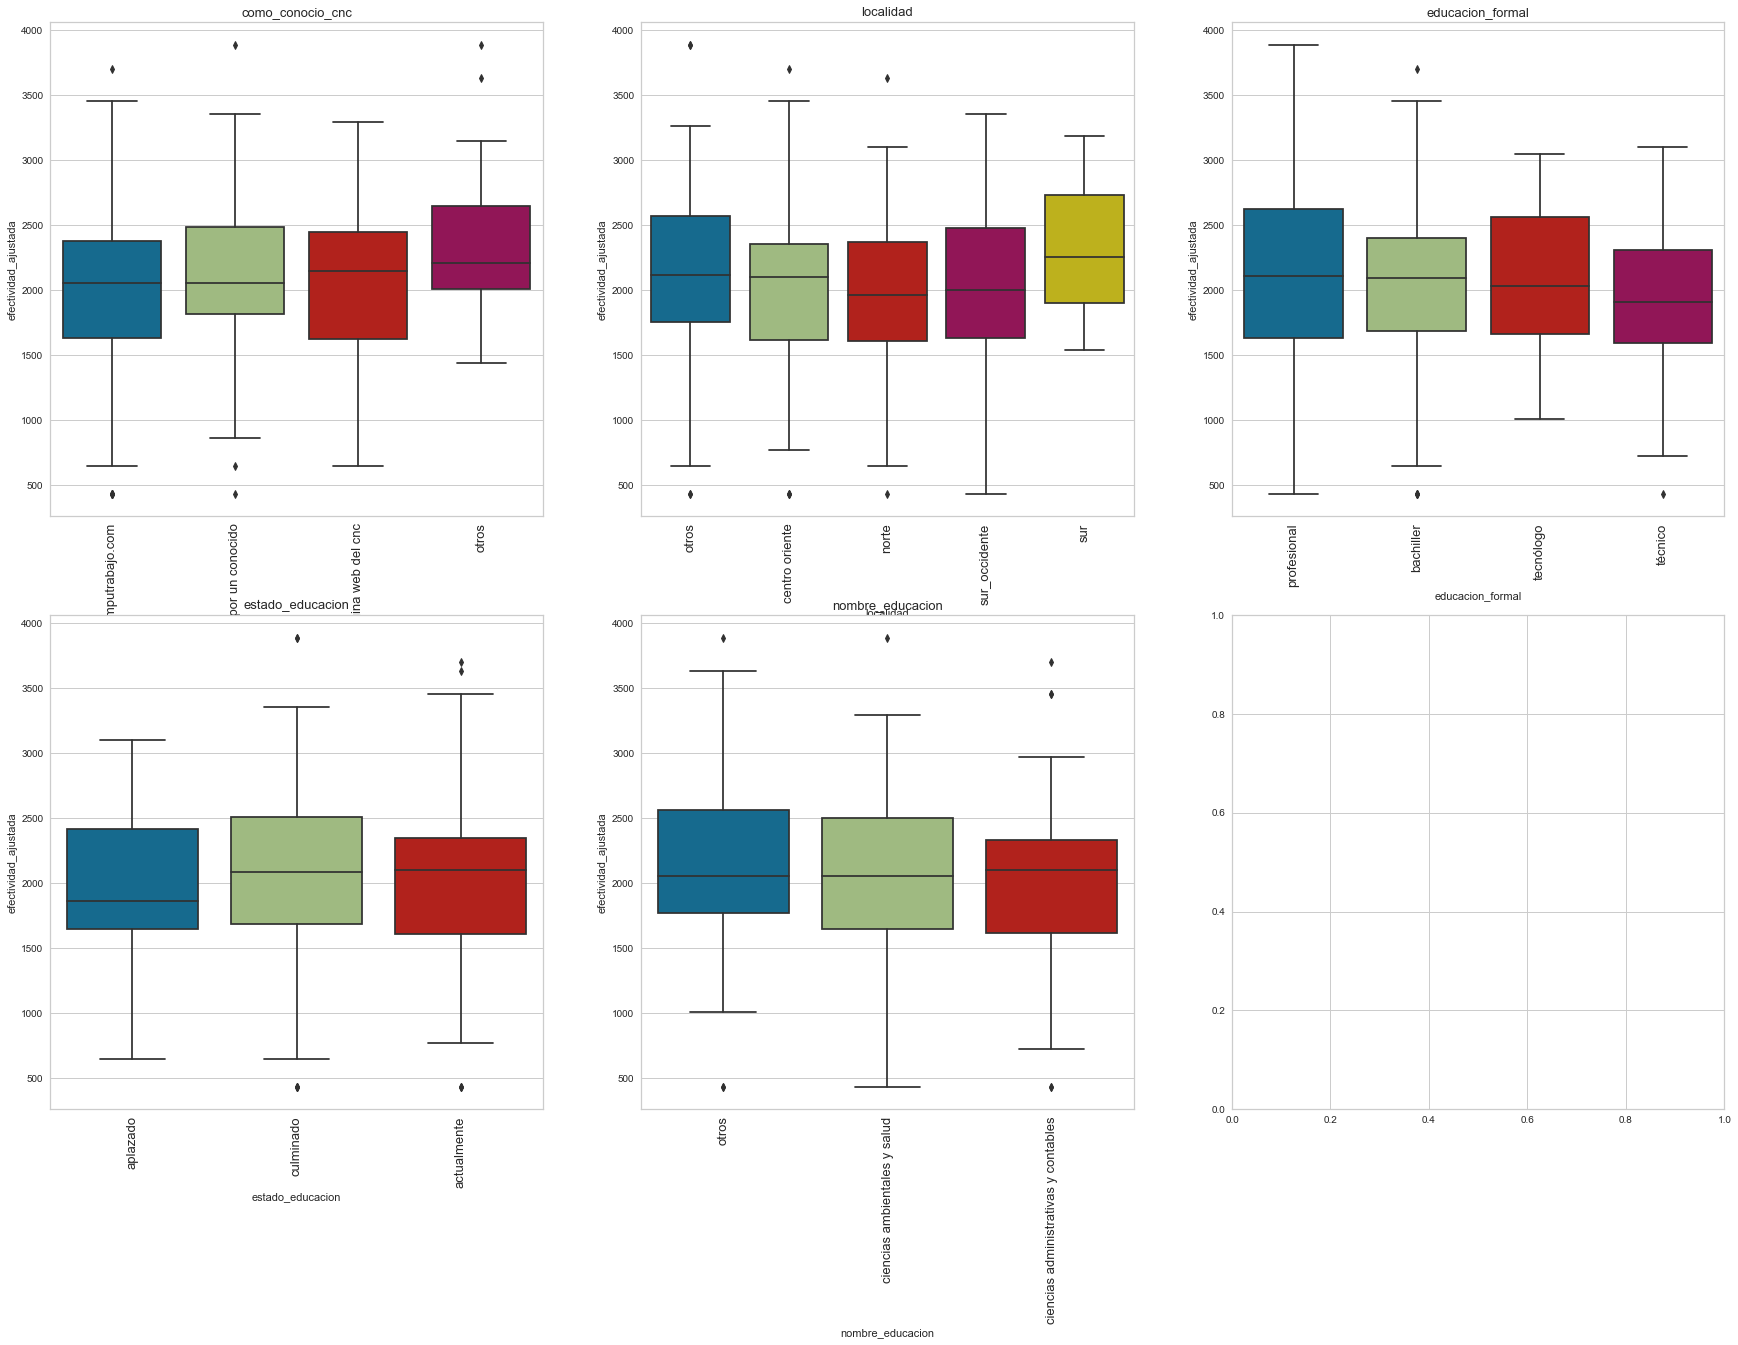

In [18]:
fig, ax = plt.subplots(ncols=3, nrows=2,figsize=(30,20))
for col, axis in zip(cols_cat, ax.flatten()):        
    ax_ = sns.boxplot(x=col,y='efectividad_ajustada',  data=df1, ax=axis)
    axis.set_title(col, fontsize=13) 
    axis.tick_params(axis="x",rotation=90, labelsize=13)

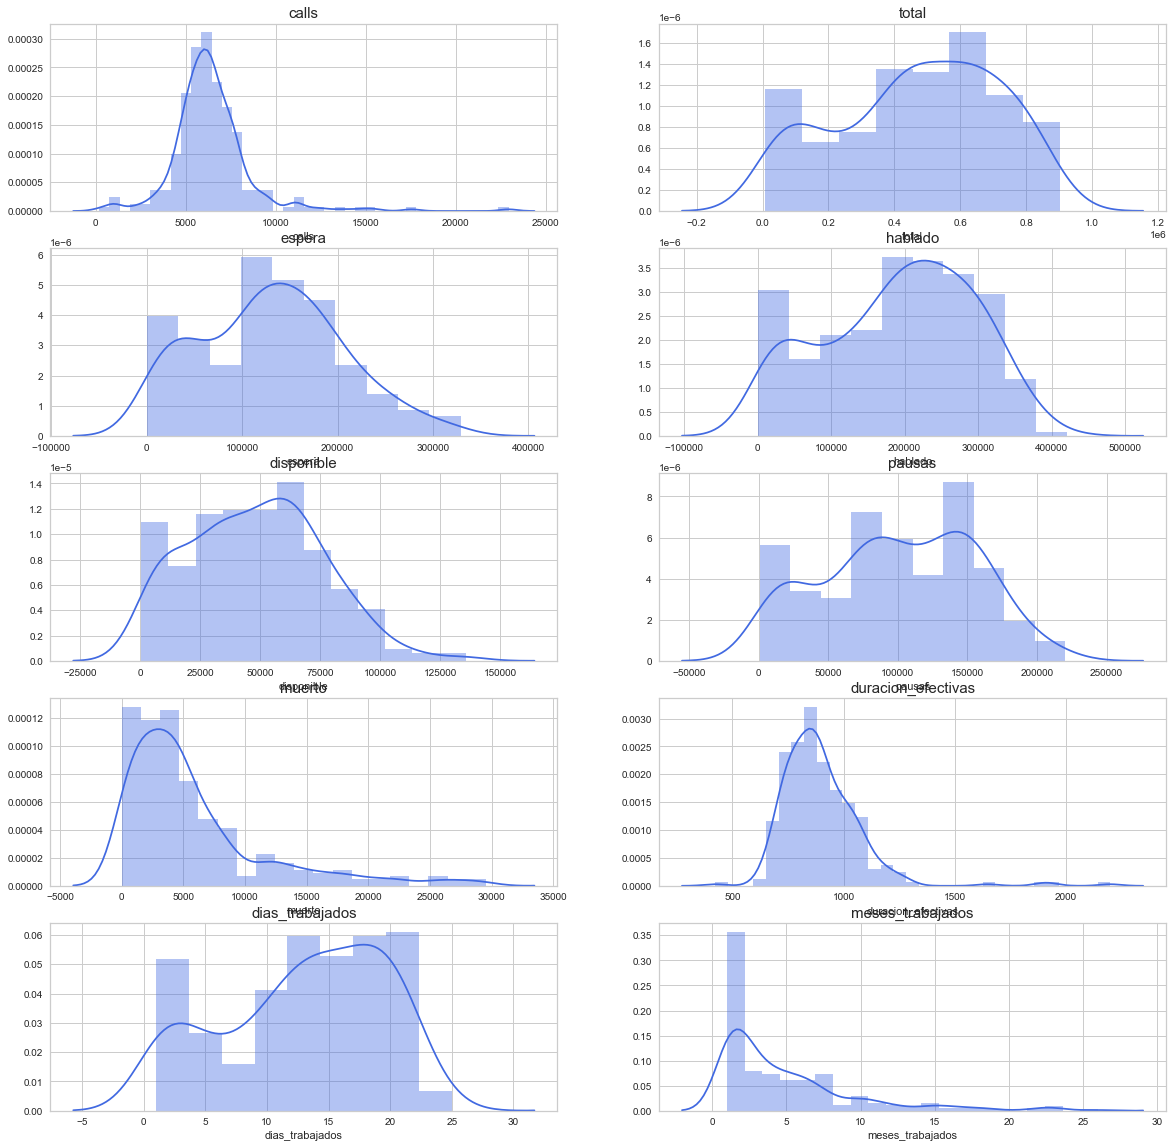

In [19]:
fig, ax = plt.subplots(ncols=2, nrows=5,figsize=(20,20))
for col, axis in zip(cols_num, ax.flatten()):        
    ax_ = sns.distplot(df1[col], ax=axis, color="royalblue")
    axis.set_title(col, fontsize=15)

In [20]:
df_dummies=pd.get_dummies(df1.drop(['codenc'],  axis=1),
            columns=['como_conocio_cnc','localidad', 'educacion_formal', 'estado_educacion','nombre_educacion'])

df_dummies.columns= df_dummies.columns.str.replace(' ','_',regex=True)
df_dummies.columns= df_dummies.columns.str.replace('-_', '',regex=True)
df_dummies.columns= df_dummies.columns.str.replace('.', '_',regex=True)

In [21]:
q1=df1['efectividad_ajustada'].quantile(q=0.33)
q2=df1['efectividad_ajustada'].quantile(q=0.66)


In [22]:
df_dummies['efectividad']=' '
df_dummies.loc[df_dummies['efectividad_ajustada']<q1, ['efectividad']]='efectividad_baja'
df_dummies.loc[((df_dummies['efectividad_ajustada']>=q1)&(df_dummies['efectividad_ajustada']<q2)), ['efectividad']]='efectividad_media'
df_dummies.loc[df_dummies['efectividad_ajustada']>=q2, ['efectividad']]='efectividad_alta'

In [23]:
df_dummies.groupby('efectividad').count()

,calls,total,espera,hablado,disponible,pausas,muerto,duracion_efectivas,dias_trabajados,efectividad_ajustada,...,educacion_formal_bachiller,educacion_formal_profesional,educacion_formal_tecnólogo,educacion_formal_técnico,estado_educacion_actualmente,estado_educacion_aplazado,estado_educacion_culminado,nombre_educacion_ciencias_administrativas_y_contables,nombre_educacion_ciencias_ambientales_y_salud,nombre_educacion_otros
efectividad,,,,,,,,,,,,,,,,,,,,,
efectividad_alta,96,96,96,96,96,96,96,96,96,96,...,96,96,96,96,96,96,96,96,96,96
efectividad_baja,94,94,94,94,94,94,94,94,94,94,...,94,94,94,94,94,94,94,94,94,94
efectividad_media,93,93,93,93,93,93,93,93,93,93,...,93,93,93,93,93,93,93,93,93,93


In [24]:
df_dummies['efectividad'].replace({'efectividad_baja':0, 'efectividad_media':1,  'efectividad_alta':2}, inplace=True)

# DESCRIPTIVE MODEL

# REGRESSION MODEL

## 1. WE WILL FIT A REGRESSION LINEAL MODEL WITH ALL VARIABLES

In [25]:
def regression_lineal(df, cols):
    reg_formula = 'efectividad_ajustada ~ ' + ' + '.join(col for col in cols)
    model = smf.ols(formula = reg_formula, data = df).fit()
    summary=model.summary()
    return summary 


def examine_multicolineality(df, cols): 
    plt.imshow(
        df[cols].corr(), # the correlation matrix
        vmin=-1,       # minimum value for the colorbar
        vmax=1,        # maximum value for the colorbar
        cmap='RdYlBu', # color scheme
    )
    plt.grid(False)

    # label the axes:
    plt.xticks(range(len(cols)), labels=cols, rotation=90)
    plt.yticks(range(len(cols)), labels=cols)
    plt.colorbar()

In [26]:
cols=['calls', 'espera', 'hablado', 'disponible', 'pausas', 'muerto' ,'duracion_efectivas', 'dias_trabajados', 
      'meses_trabajados','competencias_funcionales','numeros', 'lectura_voz_alta','fluidez_lectura', 
      'cartografia', 'competencias_organizacionales', 'sumar', 'coherencia_entre_numeros',
      'como_conocio_cnc_internet_computrabajo_com','como_conocio_cnc_internet_pagina_web_del_cnc',
      'como_conocio_cnc_otros','como_conocio_cnc_voz_a_vozreferido_por_un_conocido','localidad_centro_oriente',
      'localidad_norte', 'localidad_otros','localidad_sur', 'localidad_sur_occidente',
      'educacion_formal_bachiller', 'educacion_formal_profesional','educacion_formal_tecnólogo', 
      'educacion_formal_técnico','estado_educacion_actualmente', 'estado_educacion_aplazado',
      'estado_educacion_culminado', 'nombre_educacion_ciencias_administrativas_y_contables',
      'nombre_educacion_ciencias_ambientales_y_salud','nombre_educacion_otros']

In [27]:
#covariates=df_dummies.columns.tolist()[:7]+df_dummies.columns.tolist()[9:70]
summary_model_all=regression_lineal(df_dummies, cols)
summary_model_all

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     efectividad_ajustada   R-squared:                       0.535
Model:                              OLS   Adj. R-squared:                  0.475
Method:                   Least Squares   F-statistic:                     8.977
Date:                  Sun, 02 Aug 2020   Prob (F-statistic):           1.50e-26
Time:                          20:19:52   Log-Likelihood:                -2124.2
No. Observations:                   283   AIC:                             4314.
Df Residuals:                       250   BIC:                             4435.
Df Model:                            32                                         
Covariance Type:              nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                              2468.1249    531.736      4.642      0.000    1420.871    3515.378
calls                                                     0.0458      0.014      3.249      0.001       0.018       0.074
espera                                                   -0.0040      0.001     -4.048      0.000      -0.006      -0.002
hablado                                                   0.0036      0.001      3.227      0.001       0.001       0.006
disponible                                               -0.0045      0.002     -2.323      0.021      -0.008      -0.001
pausas                                                    0.0021      0.002      0.899      0.370      -0.003       0.007
muerto                                                   -0.0054      0.007     -0.749      0.455      -0.019       0.009
duracion_efectivas                                       -1.3741      0.176     -7.829      0.000      -1.720      -1.028
dias_trabajados                                          24.1947     20.652      1.172      0.243     -16.480      64.870
meses_trabajados                                         -0.8942      8.917     -0.100      0.920     -18.457      16.668
competencias_funcionales                                 -2.2454     50.740     -0.044      0.965    -102.178      97.687
numeros                                                  57.6458    101.891      0.566      0.572    -143.028     258.320
lectura_voz_alta                                       -489.5107    353.373     -1.385      0.167   -1185.479     206.457
fluidez_lectura                                         533.2778    352.209      1.514      0.131    -160.398    1226.953
cartografia                                              24.9901     31.864      0.784      0.434     -37.766      87.746
competencias_organizacionales                            10.8527     26.908      0.403      0.687     -42.143      63.849
sumar                                                   -42.6797     54.764     -0.779      0.437    -150.537      65.177
coherencia_entre_numeros                                -16.8927     43.170     -0.391      0.696    -101.917      68.131
como_conocio_cnc_internet_computrabajo_com              -64.7232    105.012     -0.616      0.538    -271.543     142.097
como_conocio_cnc_internet_pagina_web_del_cnc              5.5696    118.663      0.047      0.963    -228.137     239.276
como_conocio_cnc_otros                                  154.2492    132.562      1.164      0.246    -106.832     415.331
como_conocio_cnc_voz_a_vozreferido_por_un_conocido     -107.9399    112.368     -0.961      0.338    -329.249     113.369
localidad_c

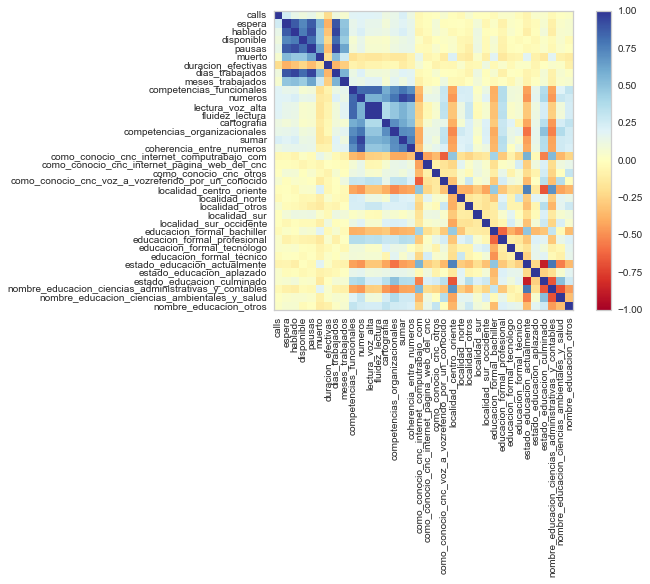

In [28]:
examine_multicolineality(df_dummies, cols)

## 2. WE WILL FIT A LINEAR A REGRESSION MODEL WITH ONLY SIGNIFICANT VARIABLES

In [29]:
cols_sig=['calls', 'hablado', 'espera', 'duracion_efectivas',  'como_conocio_cnc_internet_computrabajo_com',
'como_conocio_cnc_internet_pagina_web_del_cnc','como_conocio_cnc_otros',
'como_conocio_cnc_voz_a_vozreferido_por_un_conocido', 'localidad_centro_oriente', 
'localidad_norte', 'localidad_otros','localidad_sur', 'localidad_sur_occidente', 'educacion_formal_bachiller', 
'educacion_formal_profesional','educacion_formal_tecnólogo', 'educacion_formal_técnico',
'estado_educacion_actualmente', 'estado_educacion_aplazado' ,'estado_educacion_culminado',
'nombre_educacion_ciencias_administrativas_y_contables','nombre_educacion_ciencias_ambientales_y_salud',
'nombre_educacion_otros']

summary_model_sig=regression_lineal(df_dummies, cols_sig)
summary_model_sig


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     efectividad_ajustada   R-squared:                       0.498
Model:                              OLS   Adj. R-squared:                  0.461
Method:                   Least Squares   F-statistic:                     13.70
Date:                  Sun, 02 Aug 2020   Prob (F-statistic):           1.64e-29
Time:                          20:19:54   Log-Likelihood:                -2135.1
No. Observations:                   283   AIC:                             4310.
Df Residuals:                       263   BIC:                             4383.
Df Model:                            19                                         
Covariance Type:              nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                              2481.4173    525.703      4.720      0.000    1446.295    3516.540
calls                                                     0.0479      0.013      3.585      0.000       0.022       0.074
hablado                                                   0.0048      0.001      8.056      0.000       0.004       0.006
espera                                                   -0.0036      0.001     -4.286      0.000      -0.005      -0.002
duracion_efectivas                                       -1.4550      0.171     -8.530      0.000      -1.791      -1.119
como_conocio_cnc_internet_computrabajo_com              -25.9029    103.639     -0.250      0.803    -229.971     178.165
como_conocio_cnc_internet_pagina_web_del_cnc             21.0142    116.980      0.180      0.858    -209.322     251.351
como_conocio_cnc_otros                                  187.4184    131.438      1.426      0.155     -71.386     446.223
como_conocio_cnc_voz_a_vozreferido_por_un_conocido      -74.2585    107.915     -0.688      0.492    -286.746     138.229
localidad_centro_oriente                               -104.2199    100.606     -1.036      0.301    -302.316      93.876
localidad_norte                                           2.1646    102.534      0.021      0.983    -199.727     204.056
localidad_otros                                          52.7390    107.371      0.491      0.624    -158.677     264.155
localidad_sur                                           108.5237    112.667      0.963      0.336    -113.321     330.368
localidad_sur_occidente                                  49.0639     97.985      0.501      0.617    -143.870     241.998
educacion_formal_bachiller                              -22.3228    106.971     -0.209      0.835    -232.952     188.307
educacion_formal_profesional                            135.3654    111.916      1.210      0.228     -85.000     355.730
educacion_formal_tecnólogo                               10.8568    130.845      0.083      0.934    -246.780     268.494
educacion_formal_técnico                                -15.6281    122.557     -0.128      0.899    -256.946     225.690
estado_educacion_actualmente                            161.4837    146.948      1.099      0.273    -127.862     450.829
estado_educacion_aplazado                               -96.3971    152.905     -0.630      0.529    -397.471     204.677
estado_educacion_culminado                               43.1847    127.427      0.339      0.735    -207.722     294.092
nombre_educacion_ciencias_administrativas_y_contables    60.9869    137.244      0.444      0.657    -209.249     331.223
nombre_educ

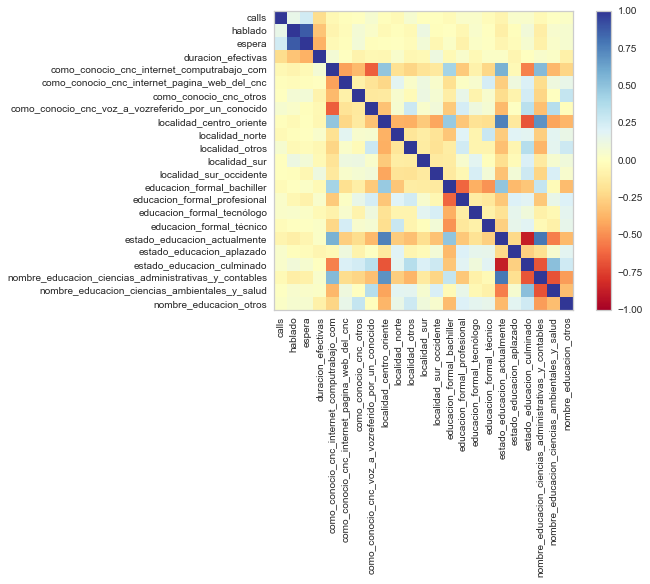

In [30]:
examine_multicolineality(df_dummies, cols_sig)

# PREDICTIVE MODELS 

# RANDOM FOREST

## WE WILL TRAIN A RANDOM FOREST MODEL

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df_dummies[cols], df_dummies['efectividad'], test_size=0.3, random_state=11) # 70% training and 30% test

In [32]:
X_train_sig=X_train[cols_sig]
X_test_sig=X_test[cols_sig]

In [33]:
def evaluate_model(model, y_test,pscore_decision, cols, num):
    #print(confusion_matrix(y_test,pscore_decision))
    #print(f"Accuracy in  dataset: {accuracy_score(y_test,pscore_decision)}")
    #print(classification_report(y_test,pscore_decision))
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    names = [cols[i] for i in indices]
    datos_importances=pd.DataFrame({'covar': names, 'coef': importances[indices]})
    sns.barplot(y='covar', x='coef', data=datos_importances.head(num))

In [34]:
clf=RandomForestClassifier(criterion='gini', max_depth=10,
                           max_features='sqrt',
                       max_leaf_nodes=4, min_samples_leaf=21,
                       min_samples_split=20, n_estimators=1000, random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
y_pred_train=clf.predict(X_train)

In [ ]:
X_train

## PERFORMANCE RANDOM FOREST MODEL

[[59  6  6]
 [18 24 21]
 [11  5 48]]
Accuracy in  dataset: 0.6616161616161617
              precision    recall  f1-score   support

           0       0.67      0.83      0.74        71
           1       0.69      0.38      0.49        63
           2       0.64      0.75      0.69        64

    accuracy                           0.66       198
   macro avg       0.67      0.65      0.64       198
weighted avg       0.67      0.66      0.65       198



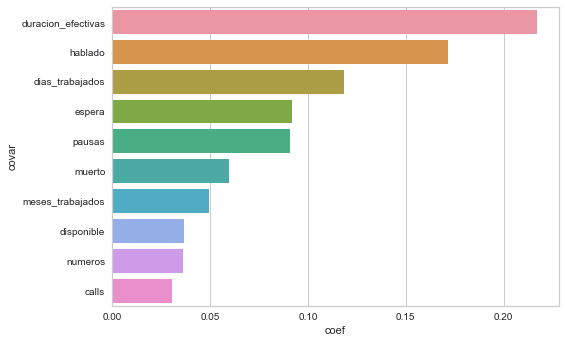

In [35]:
evaluate_model(clf,y_train,y_pred_train,cols,10)

[[18  2  3]
 [ 9  9 12]
 [ 4  2 26]]
Accuracy in  dataset: 0.6235294117647059
              precision    recall  f1-score   support

           0       0.58      0.78      0.67        23
           1       0.69      0.30      0.42        30
           2       0.63      0.81      0.71        32

    accuracy                           0.62        85
   macro avg       0.64      0.63      0.60        85
weighted avg       0.64      0.62      0.60        85



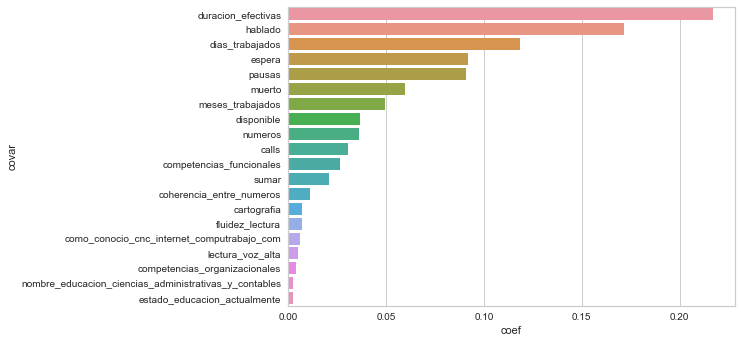

In [36]:
evaluate_model(clf,y_test,y_pred,cols,20)

In [37]:
with open('rforest.pickle', 'wb') as f:
    pickle.dump(clf, f, -1)


# KMEANS

In [203]:
df1=df1[df1['codenc']!='Encuestador 290']



In [204]:
df_model2 = df1.copy()
df_model2.columns

Index(['codenc', 'calls', 'total', 'espera', 'hablado', 'disponible', 'pausas',
       'muerto', 'duracion_efectivas', 'dias_trabajados',
       'efectividad_ajustada', 'efectivas_mujer', 'efectivas_hombre',
       'efectivas_alto', 'efectivas_medio_alto', 'efectivas_medio_medio',
       'efectivas_bajo', 'efectivas_medio_bajo', 'efectivas_tunja',
       'efectivas_popayán', 'efectivas_montería', 'efectivas_manizales',
       'efectivas_armenia', 'efectivas_villavicencio', 'efectivas_pasto',
       'efectivas_cúcuta', 'efectivas_santa_marta', 'efectivas_ibagué',
       'efectivas_neiva', 'efectivas_pereira', 'efectivas_cartagena',
       'efectivas_cali', 'efectivas_bucaramanga', 'efectivas_barranquilla',
       'efectivas_medellín', 'efectivas_bogotá', 'efectivas_rango_edad_5',
       'efectivas_rango_edad_2', 'efectivas_rango_edad_4',
       'efectivas_rango_edad_3', 'efectivas_rango_edad_1', 'meses_trabajados',
       'competencias_funcionales', 'numeros', 'lectura_voz_alta',
      

In [175]:
df_num = df1[['calls', 'total',  'muerto', 'pausas', 'hablado', 
    'duracion_efectivas',  'efectividad_ajustada', 'efectivas_alto', 
    'efectivas_medio_alto', 'efectivas_medio_medio','efectivas_bajo', 'efectivas_medio_bajo',
    'efectivas_rango_edad_5','efectivas_rango_edad_2', 'efectivas_rango_edad_4',
    'efectivas_rango_edad_3', 'efectivas_rango_edad_1', 'meses_trabajados']]

df_num.head()

,calls,total,muerto,pausas,hablado,duracion_efectivas,efectividad_ajustada,efectivas_alto,efectivas_medio_alto,efectivas_medio_medio,efectivas_bajo,efectivas_medio_bajo,efectivas_rango_edad_5,efectivas_rango_edad_2,efectivas_rango_edad_4,efectivas_rango_edad_3,efectivas_rango_edad_1,meses_trabajados
0,6252.705882,623484.000000,2193.000000,116624.000000,313690.000000,1102.323944,1804.235294,177.882353,203.294118,279.529412,838.588235,304.941176,406.588235,279.529412,279.529412,355.764706,482.823529,1
1,10989.000000,147804.000000,289.000000,30879.500000,61113.500000,954.035714,1188.000000,0.000000,0.000000,0.000000,324.000000,108.000000,216.000000,108.000000,0.000000,0.000000,108.000000,2
2,6900.927106,820764.181818,7262.818182,165926.363636,330865.454545,739.523805,2980.843057,248.805109,215.046899,366.949085,1266.635006,663.479686,413.581327,408.362482,514.200154,616.825489,807.946331,11
3,4202.400000,125574.500000,3586.500000,29410.000000,49981.500000,836.228571,2268.000000,0.000000,0.000000,367.200000,1231.200000,669.600000,583.200000,43.200000,453.600000,518.400000,669.600000,2
4,6440.057143,510847.500000,5939.500000,96874.500000,202350.000000,749.815857,1627.714286,138.857143,158.914286,222.171429,698.914286,408.857143,317.828571,388.800000,274.628571,285.428571,361.028571,2


In [205]:
# Standardize the data to have a mean of ~0 and a variance of 1
mt_std = StandardScaler().fit_transform(df_num)
mt_std.shape

(283, 18)

1    90
0    81
3    56
2    56
Name: Cluster, dtype: int64


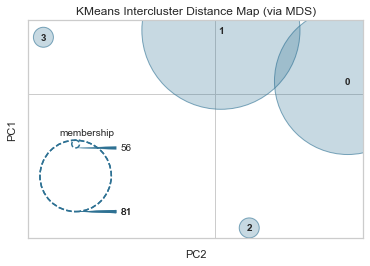

In [206]:
k_means = KMeans(init = "k-means++", n_clusters = 4, n_init=20, random_state=1234)
k_means.fit(mt_std)
df_model2['Cluster'] = k_means.labels_
print(df_model2['Cluster'].value_counts())

# Instantiate the clustering model and visualizer
visualizer = InterclusterDistance(k_means)

visualizer.fit(mt_std)        # Fit the data to the visualizer
visualizer.show()  

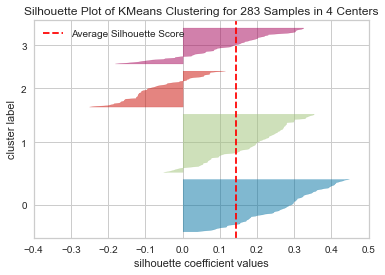

In [178]:
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(k_means, colors='yellowbrick')

visualizer.fit(mt_std)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

/Users/jessicasalas/env/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Users/jessicasalas/env/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


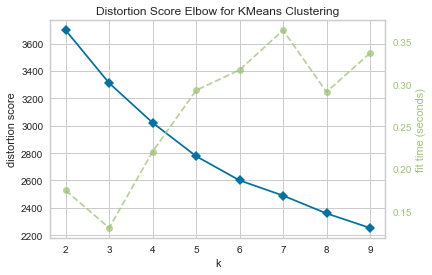

In [207]:

visualizer = KElbowVisualizer(k_means, k=(2,10))

visualizer.fit(mt_std)        # Fit the data to the visualizer
visualizer.show()    

In [210]:
pd.crosstab(df_model2['Cluster'], df_model2['educacion_formal'])

educacion_formal,bachiller,no_disponible,profesional,tecnólogo,técnico
Cluster,,,,,
0,24,8,12,9,8
1,27,3,7,3,10
2,15,5,6,2,3
3,5,5,7,6,7


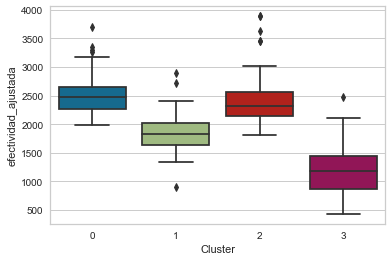

In [208]:
plt.figure(figsize=(6,4))
sns.boxplot(y='efectividad_ajustada', x='Cluster', data= df_model2)
plt.show()

In [209]:
pd.crosstab(df_model2['Cluster'], df_model2['localidad'])

localidad,centro oriente,norte,otros,sur,sur_occidente
Cluster,,,,,
0,7,12,13,14,15
1,10,11,8,8,13
2,4,4,11,1,11
3,5,11,7,1,6


In [183]:
pd.crosstab(df_model2['Cluster'], df_model2['estado_educacion'])

estado_educacion,actualmente,aplazado,culminado,no_disponible
Cluster,,,,
0,3,2,45,11
1,3,6,33,8
2,2,1,22,6
3,2,4,18,6


In [184]:
pd.crosstab(df_model2['Cluster'], df_model2['nombre_educacion'])

nombre_educacion,ciencias administrativas y contables,ciencias ambientales y salud,no_disponible,otros
Cluster,,,,
0,9,9,52,11
1,7,3,71,9
2,3,3,45,5
3,6,7,36,7


In [185]:
pd.crosstab(df_model2['Cluster'], df_model2['como_conocio_cnc'])

como_conocio_cnc,internet - computrabajo.com,internet - pagina web del cnc,internet - zonajobs.com,otros,periodico - adn,periodico - el tiempo,voz a voz- referido por un conocido
Cluster,,,,,,,
0,22,9,1,10,0,0,19
1,15,10,0,3,0,0,22
2,12,4,0,5,1,0,9
3,15,6,0,0,0,1,8


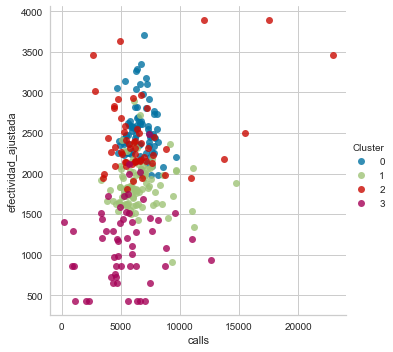

In [186]:
sns.lmplot( x="calls", y="efectividad_ajustada", data=df_model2, fit_reg=False, hue='Cluster')

In [218]:
df_radar = pd.crosstab(df_model2['Cluster'], df_model2['educacion_formal'])
#df_radar.columns=['Bachiller', 'No_disponible', 'Profesional', 'Tecnologo', 'Tecnico']
df_radar

educacion_formal,bachiller,no_disponible,profesional,tecnólogo,técnico
Cluster,,,,,
0,24,8,12,9,8
1,27,3,7,3,10
2,15,5,6,2,3
3,5,5,7,6,7


In [230]:
df_model2.columns

Index(['codenc', 'calls', 'total', 'espera', 'hablado', 'disponible', 'pausas',
       'muerto', 'duracion_efectivas', 'dias_trabajados',
       'efectividad_ajustada', 'efectivas_mujer', 'efectivas_hombre',
       'efectivas_alto', 'efectivas_medio_alto', 'efectivas_medio_medio',
       'efectivas_bajo', 'efectivas_medio_bajo', 'efectivas_tunja',
       'efectivas_popayán', 'efectivas_montería', 'efectivas_manizales',
       'efectivas_armenia', 'efectivas_villavicencio', 'efectivas_pasto',
       'efectivas_cúcuta', 'efectivas_santa_marta', 'efectivas_ibagué',
       'efectivas_neiva', 'efectivas_pereira', 'efectivas_cartagena',
       'efectivas_cali', 'efectivas_bucaramanga', 'efectivas_barranquilla',
       'efectivas_medellín', 'efectivas_bogotá', 'efectivas_rango_edad_5',
       'efectivas_rango_edad_2', 'efectivas_rango_edad_4',
       'efectivas_rango_edad_3', 'efectivas_rango_edad_1', 'meses_trabajados',
       'competencias_funcionales', 'numeros', 'lectura_voz_alta',
      

In [228]:
df_model2.to_csv('/data_etls/base_closter.csv', index=False)

(4, 6)


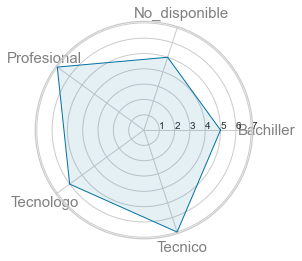

In [216]:
df_radar = pd.crosstab(df_model2['Cluster'], df_model2['educacion_formal'])
df_radar.columns=['Bachiller', 'No_disponible', 'Profesional', 'Tecnologo', 'Tecnico']
df_radar=df_radar.reset_index()
print(df_radar.shape)
df_radar.head()
# number of variable
categories=list(df_radar)[1:]
N = len(categories)

values=df_radar.loc[3].drop(['Cluster']).values.flatten().tolist()
values += values[:1]
#values

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=15)
 
# Draw ylabels
ax.set_rlabel_position(0)
#plt.yticks([10,20,30], ["10","20","30","40"], color="grey", size=7)
#plt.ylim(0,50)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)